In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.constants import e, h, c

In [3]:
# Input data and parameters
heating_voltage = 7.0 # V
accel_voltage = [6.0, 9.0, 12.0] # V
file_path = Path('Data/task2-1.csv')
columns = ['Ua', 'Ie']

data_dict = pd.read_csv(file_path, names=columns, delimiter=';', header=0, skiprows=2, dtype={'Ua': float, 'Ie': float})

In [4]:
# Truncate the data after it starts clipping, and the 164.00 value starts repeating
signal = data_dict['Ie'].values
truncated_indx = np.where(signal == 164.00)[0][0]  # Find the first occurrence of 164.00
data_dict = data_dict.iloc[:truncated_indx]

In [5]:
# Need to find peaks

# Start with taking the derivative of the data, dI/dU
# Then find the 0s of the data, but only where the derivative goes from negative to positive
# Then find the IDs of each of the zeroes
# Use the IDs to limit the peak finder range
# Iterate the peak finder over the range of IDs to find the peaks


def find_peaks(x, y):
    x_peaks = []
    y_peaks = []

    dydx = np.gradient(y, x)
    zero_crossings = np.where(np.diff(np.sign(dydx)))[0]  # Find indices where the sign changes
    print(zero_crossings)
    peak_find_indices = [0]
    for i in zero_crossings:
    ########################################################################
    # For debug:

    #print(f'{y[i]} - {y[i-1]} = {y[i] - y[i-1]}')

    ########################################################################

        if y[i] - y[i-1] < 0:
            peak_find_indices.append(i)
        elif  y[i] - y[i-2] < 0:
            peak_find_indices.append(i)

    print(peak_find_indices)
    ########################################################################
    # For debug:

    # print(peak_find_indices)
    # for i in peak_find_indices:
    #    print(f"Peak at index {i}, Ua: {x[i]}, Ie: {y[i]}")

    #print(zero_crossings)
    # for i in zero_crossings:
    #     print(f"Zero crossing at index {i}, Ua: {x[i]}, Ie: {y[i]}")

    ########################################################################


    for i in range(len(peak_find_indices)-1):
        start_value = peak_find_indices[i]
        end_value = peak_find_indices[i+1]
        mask = (x >= x[start_value]) & (x < x[end_value])
        x_segment = x[mask]
        y_segment = y[mask]
        max_index = np.argmax(y_segment)
        x_peaks.append(x_segment[max_index])
        y_peaks.append(y_segment[max_index])
        print(f"Peak at index {i}, Ua: {x_segment[max_index]}, Ie: {y_segment[max_index]}")    
    return np.array(x_peaks), np.array(y_peaks)

In [6]:
x, y = data_dict['Ua'].values, data_dict['Ie'].values
peaks = pd.DataFrame(columns=['Ua', 'Ie'])

peaks['Ua'], peaks['Ie'] = find_peaks(x, y)

[  6  10  36  53  78  89 112 125 147 162 184 200 221 232]
[0, np.int64(10), np.int64(53), np.int64(89), np.int64(125), np.int64(162), np.int64(200), np.int64(232)]
Peak at index 0, Ua: 1.14, Ie: 83.44
Peak at index 1, Ua: 5.43, Ie: 94.74
Peak at index 2, Ua: 11.43, Ie: 99.15
Peak at index 3, Ua: 16.43, Ie: 108.13
Peak at index 4, Ua: 21.43, Ie: 116.15
Peak at index 5, Ua: 26.57, Ie: 123.76
Peak at index 6, Ua: 31.86, Ie: 130.9


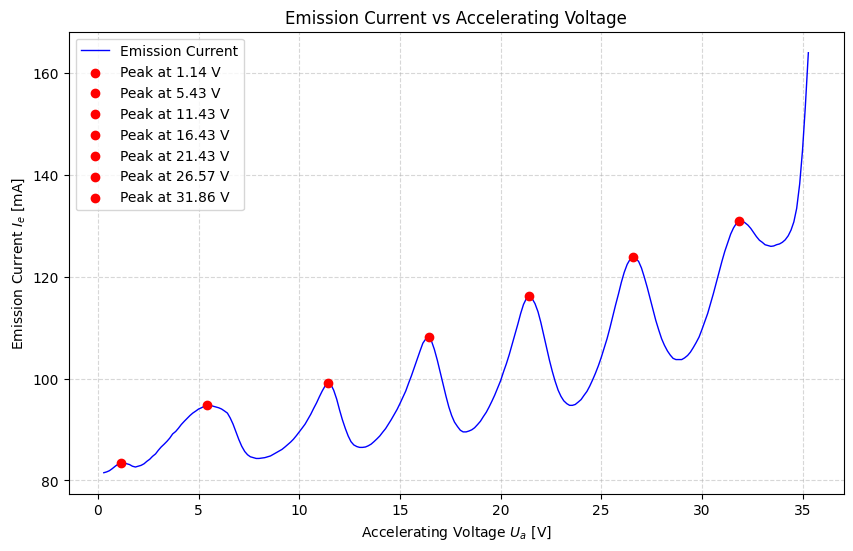

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_dict['Ua'], data_dict['Ie'], linestyle='-', lw=1,color='blue', label='Emission Current')
ax.set(
    xlabel=r'Accelerating Voltage $U_a$ [V]',
    ylabel=r'Emission Current $I_e$ [mA]',
    title='Emission Current vs Accelerating Voltage',
)


########################################################################
# For debug:
### Note: Will not work now because peak_find_indices is defined within the find_peaks function
### Need to return it from the function and use it here

# for i in peak_find_indices:
#     ax.scatter(data_dict['Ua'].iloc[i], data_dict['Ie'].iloc[i], color='red', label=f'Peak at {data_dict["Ua"].iloc[i]} V', zorder=5)

########################################################################

for data in peaks.itertuples():
    ax.scatter(data.Ua, data.Ie, color='red', label=f'Peak at {data.Ua} V', zorder=5)


ax.grid(True, linestyle='--', alpha=0.5)



ax.legend()
plt.show()

In [8]:
#print(peaks)

peak_df = pd.DataFrame(columns=[
    'Peak Number',
    'Ua [V]',
    'Ie [mA]'
])

peak_df['Peak Number'] = range(1, len(peaks)+1)
peak_df['Ua [V]'] = peaks['Ua'].values
peak_df['Ie [mA]'] = peaks['Ie'].values
peak_df['delta U_peak [V]'] = peak_df['Ua [V]'].diff()
display(peak_df)

mean_U_peak = peak_df['delta U_peak [V]'].mean()
print(f'Mean Delta U_peak [V]: {mean_U_peak}')

# nu = h * c / mean_U_peak
lambda_value = h * c / (e * mean_U_peak) #nu * 2 * np.pi
print(f'lambda = {lambda_value:.2e}')


,Peak Number,Ua [V],Ie [mA],delta U_peak [V]
0,1,1.14,83.44,NaN
1,2,5.43,94.74,4.29
2,3,11.43,99.15,6.00
3,4,16.43,108.13,5.00
4,5,21.43,116.15,5.00
5,6,26.57,123.76,5.14
6,7,31.86,130.90,5.29


Mean Delta U_peak [V]: 5.12
lambda = 2.42e-07


### Reason for weird spacing:
Second peak is quite broad, so the maximum is probably not very accurate. A shift to the right would increase the first deltaU and decrease the second deltaU. There's a total deltaU between peak 1 and peak 3 of 10.29 V, giving an average of 5.145 V per peak, which is much more in line with the rest of the data, and much closer to the theoretical value of 4.89 V.
